# Описание проекта

Федеральный оператор сотовой связи «Мегалайн» предлагает клиентам два тарифных плана: «Смарт» и «Ультра». 
Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Задача: сделать предварительный анализ тарифов на небольшой выборке клиентов. В наличии данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


# Описание тарифов

Тариф «Смарт» 
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.



# Описание данных

**Таблица users**
- `user_id` — уникальный идентификатор пользователя
- `first_name` — имя пользователя
- `last_name` — фамилия пользователя
- `age` — возраст пользователя (годы)
- `reg_date` — дата подключения тарифа (день, месяц, год)
- `churn_date` — дата прекращения пользования тарифом  (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- `city` — город проживания пользователя
- `tariff` — название тарифного плана

**Таблица calls** 
- `id` — уникальный номер звонка
- `call_date` — дата звонка
- `duration` — длительность звонка в минутах
- `user_id` — идентификатор пользователя, сделавшего звонок

**Таблица messages**
- `id` — уникальный номер сообщения
- `message_date` — дата сообщения
- `user_id` — идентификатор пользователя, отправившего сообщение

**Таблица internet**
- `id` — уникальный номер сессии
- `mb_used` —  объём потраченного за сессию интернет-трафика (в мегабайтах)
- `session_date` — дата интернет-сессии
- `user_id` — идентификатор пользователя

Таблица tariffs (информация о тарифах):
tariff_name — название тарифа
rub_monthly_fee — ежемесячная абонентская плата в рублях
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
messages_included — количество сообщений в месяц, включённых в абонентскую плату
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
rub_per_message — стоимость отправки сообщения сверх тарифного пакета
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


## Импорт библиотек, изучение данных, предобработка

In [2]:
import pandas as pd

from scipy import stats as st

import numpy as np

import matplotlib.pyplot as plt 

In [3]:
users = pd.read_csv('/datasets/users.csv') # информация о пользователях

tariffs = pd.read_csv('/datasets/tariffs.csv') # информация о тарифах

messages = pd.read_csv('/datasets/messages.csv') # информация о сообщениях

internet = pd.read_csv('/datasets/internet.csv') # информация об интернет-сессиях

calls = pd.read_csv('/datasets/calls.csv') # информация о звонках

Получим общую информацию о каждой таблице, числовое описание и первые строки

### Таблица users

In [4]:
users.info()

display(users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Колонки `churn_date` и `reg_date` необходимо привести в форомат *datetime*

In [5]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

### Таблица tariffs

In [6]:
tariffs.info()

display(tariffs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Здесь все в порядке с типом данных, но нужно переименовать колонку `tariff_name` в `tariff` для дальнейшего объединения таблиц, а также сразу перевести количество включенных мегабайт в месяц в гигабайты

In [7]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff', 
                                  'mb_per_month_included': 'gd_per_month_included'})
# переименовываем колонки

tariffs['gd_per_month_included'] = tariffs['gd_per_month_included'] / 1024
# переводим мегабайты в гигабайты

tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   gd_per_month_included  2 non-null      float64
 2   minutes_included       2 non-null      int64  
 3   rub_monthly_fee        2 non-null      int64  
 4   rub_per_gb             2 non-null      int64  
 5   rub_per_message        2 non-null      int64  
 6   rub_per_minute         2 non-null      int64  
 7   tariff                 2 non-null      object 
dtypes: float64(1), int64(6), object(1)
memory usage: 256.0+ bytes


### Таблица calls

In [8]:
calls.info()

display(calls.head())

calls.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


id звонка необходимо перевести в числовой формат, колонку` call_date` в `datetime`, `duration` округлить до целых, так как по условиям тарифов оператор округляет секунды каждого разговора до минут.

In [9]:
calls['id'] = calls['id'].astype('int')

calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

### Таблица internet

In [10]:
internet.info()

display(internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Есть лишний столбец с дублированием индексов, удалим его, id сессии приведем к целочисленному типу, `session_date` к формату *datetime*. 

In [11]:
internet['id'] = internet['id'].astype('int')

internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

internet = internet.drop(columns=['Unnamed: 0'])

### Таблица messages

In [12]:
messages.info()

display(messages.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


id сообщения приведем к целочисленному типу, `message_date` - к *datetime*

In [13]:
messages['id'] = messages['id'].astype('int')

messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

**Вывод**

Данные в таблицах приведены к нужным типам, колонки переименованы, лишний столбец в таблице `internet` удален. Отсутствующие значения в колонке `churn_date` таблицы *users* означают, что тариф еще действовал на момент выгрузки данных. Нули в колонке `duration` таблицы *calls* - пропущенные звонки, а не пропущенные значения. По условиям тарифов минуты округлены в большую сторону, а мегабайты переведены в гигабайты. 

## Расчет и добавление данных

Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя 

### Звонки, сообщения, траффик

In [14]:
calls['month'] = pd.DatetimeIndex(calls['call_date']).month 
# добавляем месяц сделанного звонка для дальнейшего расчета

calls_count = calls.groupby(
    ['user_id','month']).agg({'id':'count', 'duration': 'sum'}).reset_index()
# группируем таблицу по пользователям, считаем звонки и минуты по месяцам, удаляем мультииндекс

calls_count = calls_count.rename(columns={'id': 'calls'})
# переименовываем колонку id c количеством звонков

calls_count.head()

,user_id,month,calls,duration
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466


In [15]:
messages['month'] = pd.DatetimeIndex(messages['message_date']).month 
# добавляем месяц отправленного сообщения 
 
messages_count = messages.groupby(
    ['user_id','month']).agg({'id':'count'}).reset_index()
# группируем таблицу по количеству отправленных сообщений по месяцам, удаляем мультииндекс

messages_count = messages_count.rename(columns={'id': 'messages'})
# переименовываем колонку id с количеством сообщений 

messages_count.head()

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


По условиям тарифов общая сумма интернет-траффика за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Поэтому после подсчета использованного трафика за месяц, сумму необходимо перевести в гигабайты и округлить до целого в большую сторону.

In [16]:
internet['month'] = pd.DatetimeIndex(internet['session_date']).month 
# добавляем колонку с месяцем интернет-сессии

internet_count = internet.groupby(
    ['user_id','month']).agg({'mb_used':'sum'}).reset_index()
# группируем таблицу по количеству использованного трафика в месяц

internet_count['mb_used'] = (internet_count['mb_used'] / 1024).apply(np.ceil)
# переводим мегабайты в гигабайты, округляем в большую сторону

internet_count = internet_count.rename(columns={'mb_used': 'gb_used'})
# переименовываем колонку mb_used в gb_used

internet_count.head()

,user_id,month,gb_used
0,1000,5,3.0
1,1000,6,23.0
2,1000,7,14.0
3,1000,8,14.0
4,1000,9,15.0


Теперь у нас есть три сводных таблицы с количеством сделанных звонков, отправленных сообщений и использованного веб-траффика для каждого пользователя, чтобы подсчитать помесячную выручку с каждого абонента, необходимо склеить эти три таблицы и добавить к ним таблицы *users* и *tariff*

In [17]:
data_users = calls_count.merge(messages_count, on=['user_id', 'month'], how='outer')
# соединяем таблицу со звонками и сообщениями

data_users = data_users.merge(internet_count, on=['user_id', 'month'], how='outer')
# добавляем к таблице со звонками и сообщениями таблицу с интернет-траффиком

data_users = data_users.merge(users, on='user_id', how='left')
# добавляем таблицу с информацией о пользователях

data_users = data_users.merge(tariffs, on='tariff', how='left')
# добавляем таблицу с условиями тарифов

data_users.head()

,user_id,month,calls,duration,messages,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,gd_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22.0,159.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6,43.0,172.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7,47.0,340.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8,52.0,408.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9,58.0,466.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1


### Обработка пропусков

In [18]:
data_users.info() # общая инфо 
data_users.isna().sum() # считаем пропуски

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   int64         
 1   month                  3214 non-null   int64         
 2   calls                  3174 non-null   float64       
 3   duration               3174 non-null   float64       
 4   messages               2717 non-null   float64       
 5   gb_used                3203 non-null   float64       
 6   age                    3214 non-null   int64         
 7   churn_date             187 non-null    datetime64[ns]
 8   city                   3214 non-null   object        
 9   first_name             3214 non-null   object        
 10  last_name              3214 non-null   object        
 11  reg_date               3214 non-null   datetime64[ns]
 12  tariff                 3214 non-null   object        
 13  mes

user_id                     0
month                       0
calls                      40
duration                   40
messages                  497
gb_used                    11
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
gd_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

В итоговой таблице есть пропущенные значения звонков, сообщений и интернета - видимо, они образовались после склейки от того, что абонент например пользовался интернетом, но не звонил (в случае если сим-карта была куплена для IPad, а не для телефона). Или звонил, но не пользовался интернетом, или никогда не отправлял сообщения.
Поэтому заполним пропуски в этих категориях нулями.

In [19]:
data_users.loc[:, 
               ['calls', 'duration', 'messages', 'gb_used']
              ] = data_users.loc[:, ['calls', 'duration', 'messages', 'gb_used']].fillna(0)

In [20]:
data_users.isna().sum()
# теперь пропусков в этих колонках нет

user_id                     0
month                       0
calls                       0
duration                    0
messages                    0
gb_used                     0
age                         0
churn_date               3027
city                        0
first_name                  0
last_name                   0
reg_date                    0
tariff                      0
messages_included           0
gd_per_month_included       0
minutes_included            0
rub_monthly_fee             0
rub_per_gb                  0
rub_per_message             0
rub_per_minute              0
dtype: int64

### Расчет выручки

Считаем помесячную выручку с каждого пользователя: вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножаем на значение из тарифного плана, далее прибавляем абонентскую плату, соответствующую тарифному плану.

In [21]:
def over_paid(row):
    messages = (row['messages'] - row['messages_included']) * row['rub_per_message']
    calls = (row['calls'] - row['minutes_included']) * row['rub_per_minute']  
    internet = (row['gb_used'] - row['gd_per_month_included']) * row['rub_per_gb']
    amount = 0
    for i in [messages, calls, internet]:
        if i > 0:
            amount += i     
    return amount
    
    
data_users['over_paid'] = data_users.apply(lambda x: over_paid(x), axis=1)  
# считаем переплату для каждого пользователя сверх тарифа

In [22]:
data_users['total_paid'] = data_users['rub_monthly_fee'] + data_users['over_paid']
# добавляем абонентскую плату по тарифу, получаем итоговую выручку

In [23]:
display(data_users.head())

,user_id,month,calls,duration,messages,gb_used,age,churn_date,city,first_name,...,tariff,messages_included,gd_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,over_paid,total_paid
0,1000,5,22.0,159.0,22.0,3.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
1,1000,6,43.0,172.0,60.0,23.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
2,1000,7,47.0,340.0,75.0,14.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
3,1000,8,52.0,408.0,81.0,14.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0
4,1000,9,58.0,466.0,57.0,15.0,52,NaT,Краснодар,Рафаил,...,ultra,1000,30.0,3000,1950,150,1,1,0.0,1950.0


**Вывод**

Из 5 разных таблиц получена одна со всеми необходимыми данными, подсчитаны звонки, смс и интернет-траффик для каждого пользователя по месяцам, добавлена колонка с общей выручкой. Таблица готова для статистического анализа и построения графиков.

## Анализ данных

### Анализ поведения клиентов

Опишем поведение клиентов каждого тарифа, исходя из выборки: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям в месяц? 

In [24]:
data_smart = data_users.query('tariff == "smart"').loc[:,[
    'duration', 'messages', 'gb_used', 'total_paid']]

display(data_smart.describe())
data_smart.var()

# находим среднее, дисперсию и стандартное отклонение для "Смарта"

,duration,messages,gb_used,total_paid
count,2229.000000,2229.000000,2229.000000,2229.000000
mean,417.934948,33.384029,16.328847,1165.156572
std,190.313730,28.227876,5.747061,740.556759
min,0.000000,0.000000,0.000000,550.000000
25%,282.000000,10.000000,13.000000,550.000000
50%,422.000000,28.000000,17.000000,950.000000
75%,545.000000,51.000000,20.000000,1550.000000
max,1435.000000,143.000000,38.000000,5249.000000


duration       36219.315784
messages         796.812958
gb_used           33.028705
total_paid    548424.313445
dtype: float64

In [25]:
data_ultra = data_users.query('tariff == "ultra"').loc[:, [
    'duration', 'messages', 'gb_used', 'total_paid']]

display(data_ultra.describe())
data_ultra.var()

# находим среднее количество, дисперсию и стандартное отклонение для "Ультры"

,duration,messages,gb_used,total_paid
count,985.000000,985.000000,985.000000,985.000000
mean,526.623350,49.363452,19.494416,2070.152284
std,317.606098,47.804457,9.853511,376.187114
min,0.000000,0.000000,0.000000,1950.000000
25%,284.000000,6.000000,12.000000,1950.000000
50%,518.000000,38.000000,19.000000,1950.000000
75%,752.000000,79.000000,27.000000,1950.000000
max,1673.000000,224.000000,49.000000,4800.000000


duration      100873.633397
messages        2285.266143
gb_used           97.091686
total_paid    141516.745079
dtype: float64

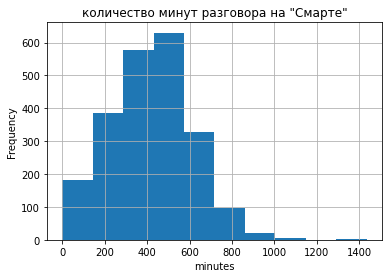

In [26]:
data_users.query('tariff == "smart"')['duration'].plot(kind='hist', grid=True)
plt.xlabel('minutes')
plt.title('количество минут разговора на "Смарте"')
plt.show()

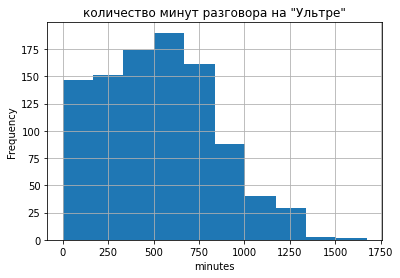

In [27]:
data_users.query('tariff == "ultra"')['duration'].plot(kind='hist', grid=True)
plt.xlabel('minutes')
plt.title('количество минут разговора на "Ультре"')
plt.show()

На Смарте люди в основном тратят весь свой лимит по звонкам - наибольшее количество значений как раз в диапазоне 450-550 минут, на Ультре в среднем разговаривают столько же, примерно 550 минут. Также видно, что есть определенное количество пользователей, которые говорят на Ультре довольно мало и видимо пользуются этим тарифом из-за включенного пакета интернет-траффика, а не количества минут.

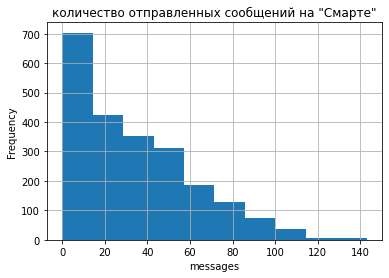

In [28]:
data_users.query('tariff == "smart"')['messages'].plot(kind='hist', grid=True)
plt.xlabel('messages')
plt.title('количество отправленных сообщений на "Смарте"')
plt.show()

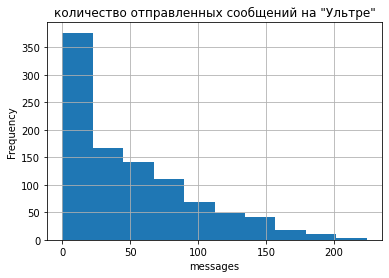

In [29]:
data_users.query('tariff == "ultra"')['messages'].plot(kind='hist', grid=True)
plt.xlabel('messages')
plt.title('количество отправленных сообщений на "Ультре"')
plt.show()

Здесь все ожидаемо: смс-сообщения сейчас не в числе популярных способов коммуникации, независимо от тарифа ими пользуются очень мало. 

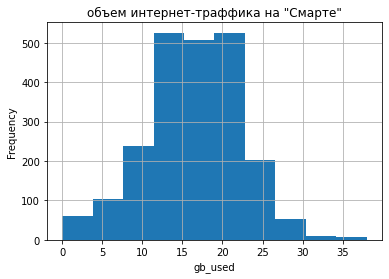

In [30]:
data_users.query('tariff == "smart"')['gb_used'].plot(kind='hist', grid=True)
plt.xlabel('gb_used')
plt.title('объем интернет-траффика на "Смарте"')
plt.show()

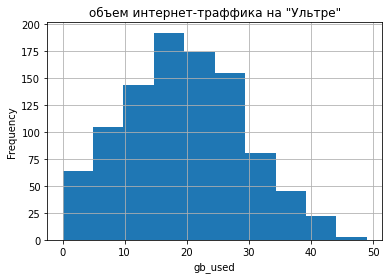

In [31]:
data_users.query('tariff == "ultra"')['gb_used'].plot(kind='hist', grid=True)
plt.xlabel('gb_used')
plt.title('объем интернет-траффика на "Ультре"')
plt.show()

На Смарте чаще превышают бесплатный лимит в 15 Гб, большому количеству абонентов нужно минимум 20. На Ультре в основном укладываются в пакет тарифа 30 Гб и многие абоненты даже тратят чуть меньше.
Пользователям Смарта, кто тратит больше чем 22 Гб трафика, было бы выгоднее перейти на Ультру.

### Анализ выручки

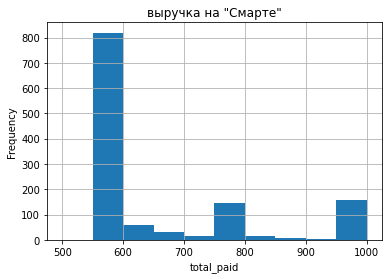

In [32]:
data_users.query('tariff == "smart"')['total_paid'].plot(
    kind='hist', grid=True, range=(500, 1000))

plt.xlabel('total_paid')
plt.title('выручка на "Смарте"')
plt.show()

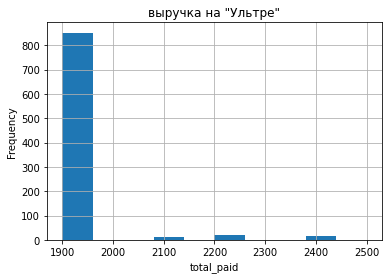

In [33]:
data_users.query('tariff == "ultra"')['total_paid'].plot(
    kind='hist', grid=True, range=(1900,2500))

plt.xlabel('total_paid')
plt.title('выручка на "Ультре"')
plt.show()

Основная часть клиентов укладываются в абонентскую плату, на графиках видны пики значений возле 550 для тарифа "Смарт" и 1950 для "Ультра", однако пользователи тарифа "Smart" чаще переплачивают, докупая интнернет-трафик, что логично - ведь в их тарифе включенный пакет Гб меньше. 

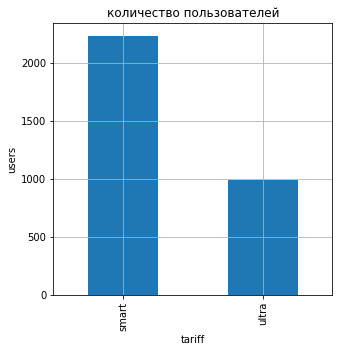

In [34]:
data_users.groupby('tariff')['tariff'].count().plot(
    y='tariff', kind='bar',figsize=(5, 5), grid=True)

plt.title('количество пользователей')
plt.ylabel('users')
plt.show()

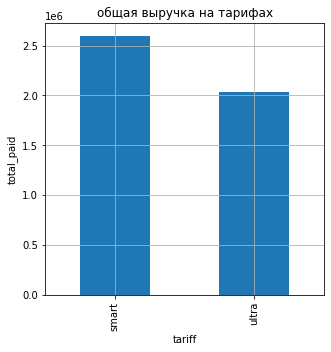

In [35]:
data_users.groupby('tariff')['total_paid'].sum().plot(
    y='total_paid', kind='bar',figsize=(5, 5), grid=True)

plt.title('общая выручка на тарифах')
plt.ylabel('total_paid')
plt.show()

На тарифе Смарт в два раза больше пользователей, чем на Ультре, что закономерно для более дешевого тарифа. Однако доходы не пропорциональны - каждая тысяча пользователей Ультры приносит всего на 20% меньше, чем две тысячи абонентов Смарта

In [36]:
def city_group(city):
    if city == 'Москва':
        return 'Москва'
    if city == 'Санкт-Петербург':
        return 'Санкт-Петербург'
    return 'Регионы'

data_users['city_group'] = data_users['city'].apply(city_group)

# добавим колонку с категориями городов для сравнения столицы и регионов

In [37]:
data_smart = data_users.query('tariff == "smart"')

data_ultra = data_users.query('tariff == "ultra"')

# группируем данные по тарифам

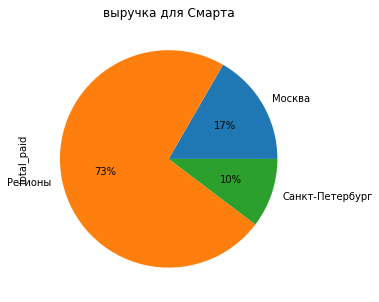

In [44]:
data_smart.groupby('city_group')['total_paid'].sum().plot(
    y='total_paid', kind='pie',figsize=(5, 5), autopct = '%.0f%%')

plt.title('выручка для Смарта')
plt.show()

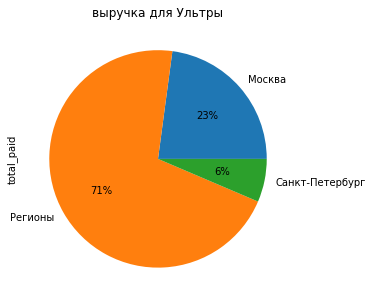

In [46]:
data_ultra.groupby('city_group')['total_paid'].sum().plot(
    y='total_paid', kind='pie',figsize=(5, 5), autopct = '%.0f%%')

plt.title('выручка для Ультры')
plt.show()

А вот здесь действительно интересно - в Москве чаще выбирают тариф Ультра, и денег соответственно он приносит больше. Для Петербурга это неактуально, там предпочитают Смарт, как и в других регионах.

**Выводы**

Большинству пользователей на двух тарифах хватает лимита в 500 минут, при этом на Ультре часто остается неиспользованными около 1000 минут. Никто из выборки абонентов Ультры не использует все 3000 включенных минут разговора, и видимо выбирают более дорогой тариф из-за пакета интернет-траффика. Это может привести к тому, что абоненты начнут задумываться о смене тарифа, а возможно и оператора. В этом случае они могут искать более дешевый тариф, ориентированный на использование мобильного интернета и с меньшим количеством минут. 

Что касается текстовых сообщений, пакет в 1000 включенных на Ультре также выглядит более чем избыточно, никто не пишет такое количество смс, многим абонентам вполне хватает лимита в 100.
На Смарте смс отправляют чуть чаще, возможно это связано с тем, что тариф более дешевый и им пользуются слои населения с более низким доходом и невысокой цифровой грамотностью вроде пенсионеров. Соответственно они меньше пользуются различными мессенджерами и предпочитают более понятные смс-сообщения.  

Примерно половине абонентов Смарта не хватает включенного интенета, и они чаще выходят за пределы лимита, докупая гигабайты. Пользователи Ультры в основном укладываются в условия основного пакета.

Абонентов Смарта в выборке больше, чем абонентов Ультры, и денег этот тариф поэтому приносит больше, однако если взять равное количество, то Ультра выгоднее для оператора. Несмотря на переплаты за интернет на более дешевом тарифе, более дорогой приносит больше выручки. 

В регионах более популярен Смарт, а в Москве - Ультра, это следует учесть при разработке рекламных кампаний.

## Проверка гипотез

- Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Так как генеральные совокупности в данном исследовании не зависят друг от друга, нужен метод проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.


**H0:Средняя выручка пользователей тарифов «Ультра» и «Смарт» равна;**

**H1:Средняя выручка пользователей тарифов «Ультра» и «Смарт» не равна;**
    

In [40]:
smart = data_users.query('tariff == "smart"')['total_paid']

ultra = data_users.query('tariff == "ultra"')['total_paid']

In [41]:
alpha = 0.01

results = st.ttest_ind(ultra, smart)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 1.7908299298705238e-242
Отвергаем нулевую гипотезу


Итог: выручка пользователей тарифов «Ультра» и «Смарт» действительно различаются.

**H0:Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов;**

**Н1:Средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов;**

In [42]:
print(data_users['city'].unique())

moscow = data_users.query('city == "Москва"')['total_paid']

regions = data_users.query('city != "Москва"')['total_paid']

['Краснодар' 'Москва' 'Стерлитамак' 'Новокузнецк' 'Набережные Челны'
 'Ульяновск' 'Челябинск' 'Пермь' 'Тюмень' 'Самара' 'Санкт-Петербург'
 'Иваново' 'Чебоксары' 'Омск' 'Уфа' 'Томск' 'Чита' 'Мурманск'
 'Петрозаводск' 'Тверь' 'Екатеринбург' 'Махачкала' 'Вологда' 'Череповец'
 'Ярославль' 'Сочи' 'Хабаровск' 'Ставрополь' 'Рязань' 'Улан-Удэ' 'Тула'
 'Саратов' 'Ростов-на-Дону' 'Казань' 'Иркутск' 'Курск' 'Калуга' 'Якутск'
 'Астрахань' 'Химки' 'Владикавказ' 'Волгоград' 'Саранск' 'Ижевск'
 'Новосибирск' 'Брянск' 'Тольятти' 'Нижний Тагил' 'Орёл' 'Белгород'
 'Воронеж' 'Курган' 'Барнаул' 'Красноярск' 'Архангельск' 'Липецк'
 'Кемерово' 'Киров' 'Сургут' 'Пенза' 'Волжский' 'Магнитогорск'
 'Нижний Новгород' 'Кострома' 'Владивосток' 'Тамбов' 'Балашиха'
 'Севастополь' 'Калининград' 'Оренбург' 'Смоленск' 'Нижневартовск'
 'Владимир' 'Новороссийск' 'Грозный' 'Подольск']


In [43]:
alpha = 0.01

results = st.ttest_ind(moscow, regions)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.2959013162901812
Не получилось отвергнуть нулевую гипотезу


Итог: удивительно, но выручка пользователей из Москвы и регионов не отличается.

## Общие выводы  и рекомендации

Выгоднее вкладываться в рекламу тарифа Ультра, он приносит больше денег, привлечение большего количества пользователей даст в итоге больше выручки. Однако можно рассмотреть разный таргетинг на Москву и регионы - в Москве рекламировать Ультру, в регионах можно сделать ставку на Смарт.

Но прежде чем рекламировать какой-либо тариф, оператору стоит пересмотреть актуальность предлагаемых условий и привлекательность их для потенциальных абонентов. На Смарте люди чаще переплачивают, на Ультре остаются неизрасходованные излишки, что может привести в итоге к уходу к другому оперетору с более гибкими и выгодными предложениями. К примеру, на Ультре можно было бы переносить остатки на следующий месяц или конвертировать непотраченные минуты в гигабайты и наоборот.

Разброс в цене между тарифами слишком велик, поэтому многим психологически комфортнее выбрать более дешевый из двух. Помимо оптимизации существующих тарифов хорошим вариантом может быть запуск нового, который будет включать около 500 минут разговора, не более 100 сообщений и не менее 20 Гб интернета, при этом стоить больше, чем Смарт и значительно меньше, чем Ультра. Такая стратегия может удовлетворить основные нужды большинства абонентов, не заставляя их постоянно переплачивать и при этом не задумываться о смене тарифа вследствие неиспользованного включенного пакета.